In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import chi2_contingency
import statsmodels.formula.api as smf
import scipy.stats as stats
from scipy.stats import shapiro
from scipy.stats import levene
import scikit_posthocs as sp
from scipy.stats import f_oneway
from scipy.stats import kruskal
import scikit_posthocs as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import friedmanchisquare
from scipy.stats import wilcoxon
from itertools import combinations
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [5]:
df = pd.read_excel("C:/Users/...../Excel/AIOutput.xlsx")

df

,ID,Prompt,Cluster,Batch,Classification,Alignment,Explanation,Precision
0,1,Zero,stage_1,1,1,3,2,2
1,1,Two,stage_1,1,1,1,2,1
2,1,Four,stage_1,1,1,1,1,0
3,2,Zero,stage_1,1,0,0,0,0
4,2,Two,stage_1,1,1,1,1,1
...,...,...,...,...,...,...,...,...
217,73,Two,stage_5,1,1,1,0,0
218,73,Four,stage_5,1,1,1,1,0
219,74,Zero,stage_5,1,0,0,0,0
220,74,Two,stage_5,1,0,0,0,0


In [3]:
df.describe()

,ID,Batch,Classification,Alignment,Explanation,Precision
count,222.000000,222.0,222.000000,222.000000,222.000000,222.000000
mean,37.500000,1.0,0.608108,1.211712,1.166667,0.612613
std,21.408281,0.0,0.489276,1.463043,0.953283,1.081905
min,1.000000,1.0,0.000000,0.000000,0.000000,0.000000
25%,19.000000,1.0,0.000000,0.000000,1.000000,0.000000
50%,37.500000,1.0,1.000000,1.000000,1.000000,0.000000
75%,56.000000,1.0,1.000000,2.000000,1.000000,1.000000
max,74.000000,1.0,1.000000,5.000000,5.000000,5.000000


In [9]:
X = df[['Classification', 'Alignment', 'Explanation', 'Precision']]

X = add_constant(X)
X = X.drop('const', axis=1)

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

          feature       VIF
0  Classification  3.583115
1       Alignment  6.876721
2     Explanation  3.369649
3       Precision  4.812864


# Classifications

In [5]:
cluster_errors = df[df['Classification'] == 0].groupby('Cluster').size().reset_index(name='Misclassifications')

cluster_errors_sorted = cluster_errors.sort_values(by='Misclassifications', ascending=False)

print(cluster_errors_sorted)

   Cluster  Misclassifications
2  stage_3                  25
1  stage_2                  21
0  stage_1                  16
4  stage_5                  14
3  stage_4                  11


In [6]:
misclassifications = df[df['Classification'] == 0].groupby('Cluster').size().reset_index(name='Misclassifications')

total_per_cluster = df.groupby('Cluster').size().reset_index(name='Total')

cluster_stats = misclassifications.merge(total_per_cluster, on='Cluster')

cluster_stats['Error Rate (%)'] = 100 * cluster_stats['Misclassifications'] / cluster_stats['Total']

cluster_stats_sorted = cluster_stats.sort_values(by='Error Rate (%)', ascending=False)

print(cluster_stats_sorted)

   Cluster  Misclassifications  Total  Error Rate (%)
4  stage_5                  14     33       42.424242
3  stage_4                  11     27       40.740741
1  stage_2                  21     54       38.888889
0  stage_1                  16     42       38.095238
2  stage_3                  25     66       37.878788


### Cluster

In [8]:
contingency_table = pd.crosstab(df['Cluster'], df['Classification'])

chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square test statistic: {chi2:.4f}")
print(f"p-value: {p:.4f}")

if p < 0.05:
    print("There is a statistically significant association between Cluster and Classification (misclassification rates differ).")
else:
    print("No statistically significant association found between Cluster and Classification.")


Chi-square test statistic: 0.2429
p-value: 0.9932
No statistically significant association found between Cluster and Classification.


In [9]:
df['Misclassified'] = 1 - df['Classification']

model = smf.logit("Misclassified ~ C(Cluster)", data=df).fit()

print(model.summary())

Optimization terminated successfully.
         Current function value: 0.669042
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:          Misclassified   No. Observations:                  222
Model:                          Logit   Df Residuals:                      217
Method:                           MLE   Df Model:                            4
Date:                Sat, 17 May 2025   Pseudo R-squ.:               0.0008131
Time:                        15:01:04   Log-Likelihood:                -148.53
converged:                       True   LL-Null:                       -148.65
Covariance Type:            nonrobust   LLR p-value:                    0.9933
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.4855      0.318     -1.528      0.127      -1.108       0.

### Prompting

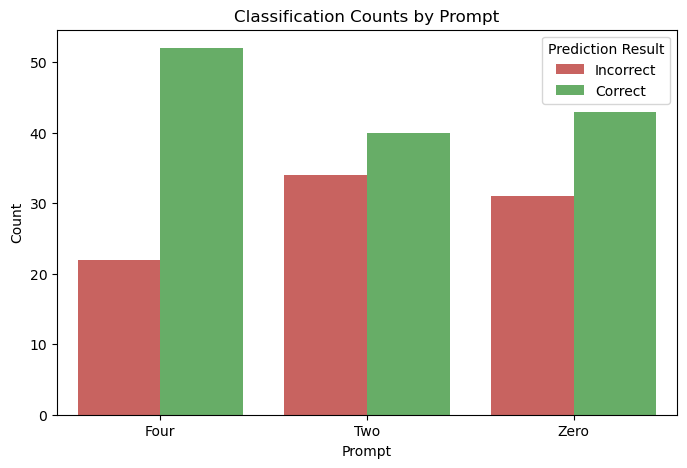

In [145]:
classification_counts = df.groupby(['Prompt', 'Classification']).size().reset_index(name='Count')

classification_counts['Prediction Result'] = classification_counts['Classification'].map({0: 'Incorrect', 1: 'Correct'})

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(
    data=classification_counts,
    x='Prompt',
    y='Count',
    hue='Prediction Result',
    palette={'Incorrect': '#d9534f', 'Correct': '#5cb85c'}
)
plt.title('Classification Counts by Prompt')
plt.show()

In [12]:
contingency_table = pd.crosstab(df['Prompt'], df['Classification'])
print(contingency_table)

chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic = {chi2:.4f}")
print(f"p-value = {p:.4f}")

Classification   0   1
Prompt                
Four            22  52
Two             34  40
Zero            31  43
Chi-square statistic = 4.4230
p-value = 0.1095


# Alignment

In [14]:
alignment_by_cluster = df.groupby('Cluster')['Alignment'].mean().reset_index()
alignment_by_cluster = alignment_by_cluster.sort_values(by='Alignment', ascending=False)

print(alignment_by_cluster)

   Cluster  Alignment
3  stage_4   1.407407
1  stage_2   1.370370
2  stage_3   1.227273
0  stage_1   1.190476
4  stage_5   0.787879


In [15]:
alignment_by_prompt = df.groupby('Prompt')['Alignment'].mean().reset_index()
alignment_by_prompt = alignment_by_prompt.sort_values(by='Alignment', ascending=False)

print(alignment_by_prompt)


  Prompt  Alignment
2   Zero   1.567568
0   Four   1.216216
1    Two   0.851351


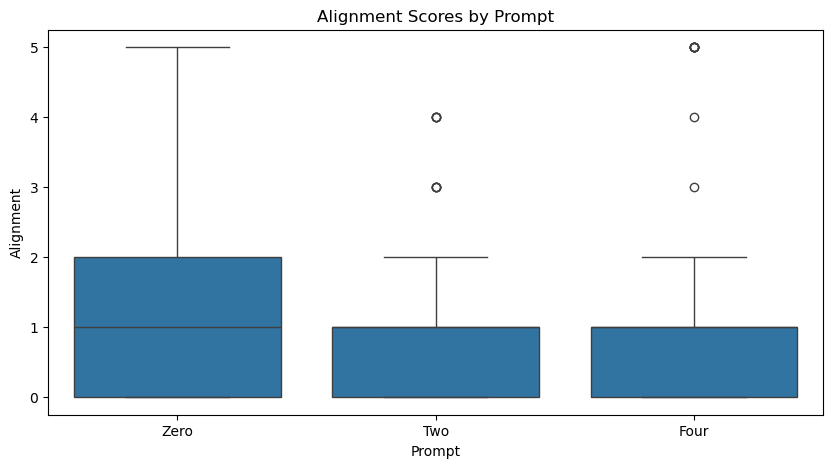

Shapiro test for Zero: W=0.817, p=0.000
Shapiro test for Two: W=0.731, p=0.000
Shapiro test for Four: W=0.686, p=0.000
Levene's test: Stat=6.419, p=0.002


In [16]:
# Plot
plt.figure(figsize=(10,5))
sns.boxplot(x='Prompt', y='Alignment', data=df)
plt.title('Alignment Scores by Prompt')
plt.show()

# Test for normality of Alignment within each Prompt
for prompt in df['Prompt'].unique():
    w, pvalue = stats.shapiro(df.loc[df['Prompt'] == prompt, 'Alignment'])
    print(f'Shapiro test for {prompt}: W={w:.3f}, p={pvalue:.3f}')

# Test for homogeneity of variances
levene_stat, levene_p = stats.levene(*[df.loc[df['Prompt'] == p, 'Alignment'] for p in df['Prompt'].unique()])
print(f"Levene's test: Stat={levene_stat:.3f}, p={levene_p:.3f}")

In [123]:
def friedman_test_repeated_measures(df, id_col, group_col, value_col):
    print(f"\n# Friedman Test for Related Samples")
    print(f"H0: The distributions of {value_col} are the same across {group_col} groups")
    print(f"H1: At least one {group_col} group differs\n")
    
    df_wide = df.pivot(index=id_col, columns=group_col, values=value_col).dropna()
    
    groups = df_wide.columns.tolist()
    print(f"Groups found: {groups}")
    
    data_for_test = [df_wide[group] for group in groups]
    
    if any(len(g) == 0 for g in data_for_test):
        print("Not enough data in one or more groups for testing.")
        return
    
    friedman_stat, friedman_p = stats.friedmanchisquare(*data_for_test)
    print(f"Friedman test: Chi-square = {friedman_stat:.3f}, p = {friedman_p:.3f}\n")
    
    if friedman_p < 0.05:
        print("Significant differences found. Post-hoc Wilcoxon signed-rank tests (Bonferroni corrected):\n")
        results = []

        for g1, g2 in combinations(groups, 2):
            stat, p = stats.wilcoxon(df_wide[g1], df_wide[g2])
            p_adj = min(p * 3, 1.0)  # 3 comparisons total → Bonferroni correction
            results.append({
                'Comparison': f"{g1} vs {g2}",
                'Wilcoxon Statistic': round(stat, 3),
                'Raw p-value': round(p, 4),
                'Bonferroni p': round(p_adj, 4)
            })

        posthoc_df = pd.DataFrame(results)
        print(posthoc_df.to_string(index=False))
    else:
        print("No significant differences found. Post-hoc tests not performed.")

friedman_test_repeated_measures(df, id_col='ID', group_col='Prompt', value_col='Alignment')


# Friedman Test for Related Samples
H0: The distributions of Alignment are the same across Prompt groups
H1: At least one Prompt group differs

Groups found: ['Four', 'Two', 'Zero']
Friedman test: Chi-square = 7.193, p = 0.027

Significant differences found. Post-hoc Wilcoxon signed-rank tests (Bonferroni corrected):

  Comparison  Wilcoxon Statistic  Raw p-value  Bonferroni p
 Four vs Two               402.0       0.0764        0.2292
Four vs Zero               546.0       0.1282        0.3846
 Two vs Zero               394.0       0.0040        0.0121


# Explanation

In [99]:
explanation_by_cluster = df.groupby('Cluster')['Explanation'].agg(['mean', 'std', 'count']).reset_index()
explanation_by_cluster = explanation_by_cluster.sort_values(by='mean', ascending=False)

print(explanation_by_cluster)

   Cluster      mean       std  count
1  stage_2  1.388889  1.053595     54
0  stage_1  1.309524  0.975007     42
3  stage_4  1.222222  1.187542     27
2  stage_3  1.060606  0.839025     66
4  stage_5  0.787879  0.599874     33


C:\Users\......\ipykernel_14268\1236709420.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=df, x='Cluster', y='Explanation', ci='sd', palette='viridis')
C:\Users\......\ipykernel_14268\1236709420.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Cluster', y='Explanation', ci='sd', palette='viridis')


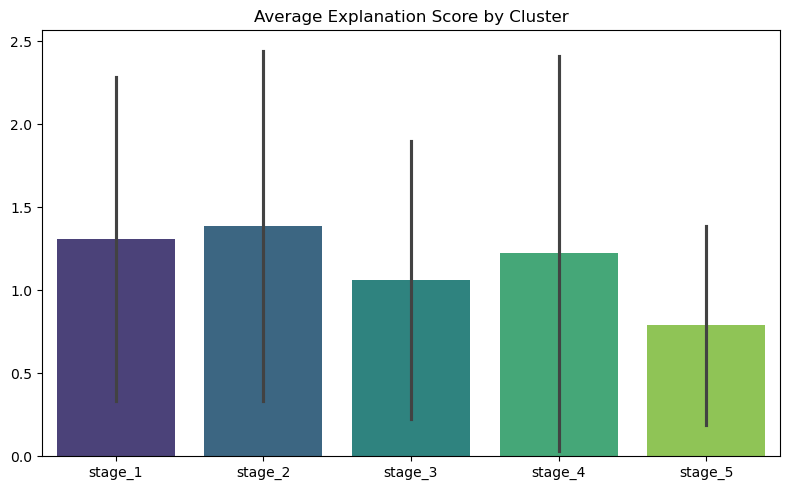

In [105]:
# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x='Cluster', y='Explanation', ci='sd', palette='viridis')
plt.title('Average Explanation Score by Cluster')
plt.ylabel('')
plt.xlabel('')
plt.tight_layout()
plt.show()

In [22]:
for cluster in df['Cluster'].unique():
    w, p = shapiro(df[df['Cluster'] == cluster]['Explanation'])
    print(f'Shapiro test for {cluster}: W={w:.3f}, p={p:.3f}')

Shapiro test for stage_1: W=0.751, p=0.000
Shapiro test for stage_2: W=0.831, p=0.000
Shapiro test for stage_3: W=0.847, p=0.000
Shapiro test for stage_4: W=0.675, p=0.000
Shapiro test for stage_5: W=0.758, p=0.000


In [125]:
def friedman_test_repeated_measures(df, id_col, group_col, value_col):
    print(f"\n# Friedman Test for Related Samples")
    print(f"H0: The distributions of {value_col} are the same across {group_col} groups")
    print(f"H1: At least one {group_col} group differs\n")
    
    df_wide = df.pivot(index=id_col, columns=group_col, values=value_col).dropna()
    
    groups = df_wide.columns.tolist()
    print(f"Groups found: {groups}")
    
    data_for_test = [df_wide[group] for group in groups]
    
    if any(len(g) == 0 for g in data_for_test):
        print("Not enough data in one or more groups for testing.")
        return
    
    friedman_stat, friedman_p = stats.friedmanchisquare(*data_for_test)
    print(f"Friedman test: Chi-square = {friedman_stat:.3f}, p = {friedman_p:.3f}\n")
    
    # Post-hoc if significant
    if friedman_p < 0.05:
        print("Significant differences found. Post-hoc Wilcoxon signed-rank tests (Bonferroni corrected):\n")
        results = []

        for g1, g2 in combinations(groups, 2):
            stat, p = stats.wilcoxon(df_wide[g1], df_wide[g2])
            p_adj = min(p * 3, 1.0)  # 3 comparisons total → Bonferroni correction
            results.append({
                'Comparison': f"{g1} vs {g2}",
                'Wilcoxon Statistic': round(stat, 3),
                'Raw p-value': round(p, 4),
                'Bonferroni p': round(p_adj, 4)
            })

        posthoc_df = pd.DataFrame(results)
        print(posthoc_df.to_string(index=False))
    else:
        print("No significant differences found. Post-hoc tests not performed.")

friedman_test_repeated_measures(df, id_col='ID', group_col='Prompt', value_col='Explanation')


# Friedman Test for Related Samples
H0: The distributions of Explanation are the same across Prompt groups
H1: At least one Prompt group differs

Groups found: ['Four', 'Two', 'Zero']
Friedman test: Chi-square = 7.753, p = 0.021

Significant differences found. Post-hoc Wilcoxon signed-rank tests (Bonferroni corrected):

  Comparison  Wilcoxon Statistic  Raw p-value  Bonferroni p
 Four vs Two               237.5       0.1057        0.3172
Four vs Zero               905.5       0.7629        1.0000
 Two vs Zero               660.0       0.3424        1.0000


# Precision

In [26]:
precision_by_cluster = df.groupby('Cluster')['Precision'].agg(['mean', 'std', 'count']).reset_index()
precision_by_cluster = precision_by_cluster.sort_values(by='mean', ascending=False)
print(precision_by_cluster)


   Cluster      mean       std  count
1  stage_2  0.814815  1.346891     54
3  stage_4  0.666667  1.330124     27
0  stage_1  0.642857  1.055102     42
2  stage_3  0.545455  0.862587     66
4  stage_5  0.333333  0.735980     33


C:\Users\......\ipykernel_14268\1312063206.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=df, x='Cluster', y='Precision', ci='sd', palette='coolwarm')
C:\Users\......\ipykernel_14268\1312063206.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Cluster', y='Precision', ci='sd', palette='coolwarm')


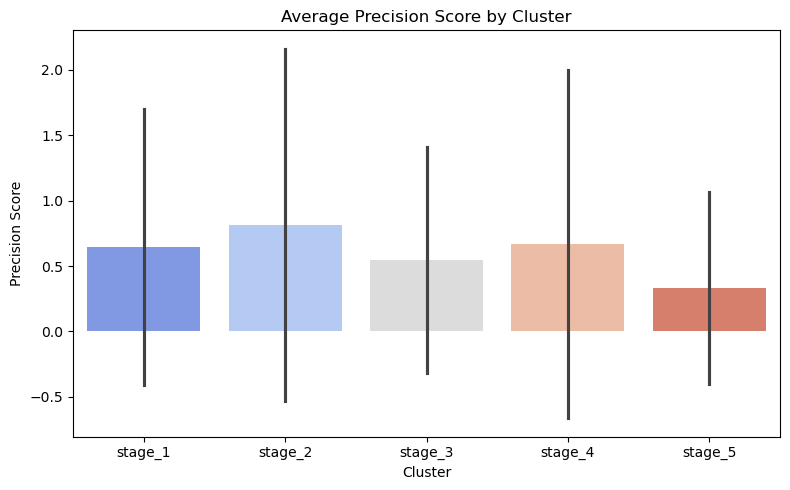

In [27]:
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x='Cluster', y='Precision', ci='sd', palette='coolwarm')
plt.title('Average Precision Score by Cluster')
plt.ylabel('Precision Score')
plt.xlabel('Cluster')
plt.tight_layout()
plt.show()

In [155]:
def friedman_test_repeated_measures(df, id_col, group_col, value_col):
    print(f"\n# Friedman Test for Related Samples")
    print(f"H0: The distributions of {value_col} are the same across {group_col} groups")
    print(f"H1: At least one {group_col} group differs\n")
    
    df_wide = df.pivot(index=id_col, columns=group_col, values=value_col).dropna()
    
    groups = df_wide.columns.tolist()
    print(f"Groups found: {groups}")
    
    data_for_test = [df_wide[group] for group in groups]
    
    if any(len(g) == 0 for g in data_for_test):
        print("Not enough data in one or more groups for testing.")
        return
    
    friedman_stat, friedman_p = stats.friedmanchisquare(*data_for_test)
    print(f"Friedman test: Chi-square = {friedman_stat:.3f}, p = {friedman_p:.3f}\n")
    
    if friedman_p < 0.05:
        print("Significant differences found. Post-hoc Wilcoxon signed-rank tests (Bonferroni corrected):\n")
        results = []

        for g1, g2 in combinations(groups, 2):
            stat, p = stats.wilcoxon(df_wide[g1], df_wide[g2])
            p_adj = min(p * 3, 1.0)  # 3 comparisons total → Bonferroni correction
            results.append({
                'Comparison': f"{g1} vs {g2}",
                'Wilcoxon Statistic': round(stat, 3),
                'Raw p-value': round(p, 4),
                'Bonferroni p': round(p_adj, 4)
            })

        posthoc_df = pd.DataFrame(results)
        print(posthoc_df.to_string(index=False))
    else:
        print("No significant differences found. Post-hoc tests not performed.")

friedman_test_repeated_measures(df, id_col='ID', group_col='Prompt', value_col='Precision')


# Friedman Test for Related Samples
H0: The distributions of Precision are the same across Prompt groups
H1: At least one Prompt group differs

Groups found: ['Four', 'Two', 'Zero']
Friedman test: Chi-square = 15.155, p = 0.001

Significant differences found. Post-hoc Wilcoxon signed-rank tests (Bonferroni corrected):

  Comparison  Wilcoxon Statistic  Raw p-value  Bonferroni p
 Four vs Two               158.5       0.1907        0.5721
Four vs Zero               132.0       0.0002        0.0005
 Two vs Zero               305.0       0.0046        0.0138


# All At Once

In [133]:
cluster_means = df.groupby('Cluster')[['Alignment', 'Explanation', 'Precision']].mean()
print("Mean scores by Cluster:")
print(cluster_means)

prompt_means = df.groupby('Prompt')[['Alignment', 'Explanation', 'Precision']].mean()
print("\nMean scores by Prompt:")
print(prompt_means)

Mean scores by Cluster:
         Alignment  Explanation  Precision
Cluster                                   
stage_1   1.190476     1.309524   0.642857
stage_2   1.370370     1.388889   0.814815
stage_3   1.227273     1.060606   0.545455
stage_4   1.407407     1.222222   0.666667
stage_5   0.787879     0.787879   0.333333

Mean scores by Prompt:
        Alignment  Explanation  Precision
Prompt                                   
Four     1.216216     1.108108   0.297297
Two      0.851351     1.270270   0.486486
Zero     1.567568     1.121622   1.054054


In [135]:
variables = ['Alignment', 'Explanation', 'Precision']
groups = df['Cluster'].unique()

for var in variables:
    print(f"\nTesting {var} by Cluster:")
    data_by_group = [df[df['Cluster'] == g][var].dropna() for g in groups]
    
    kw_stat, kw_p = kruskal(*data_by_group)
    print(f"Kruskal-Wallis H={kw_stat:.3f}, p={kw_p:.3f}")
    
    if kw_p < 0.05:
        print("Significant differences found, running post-hoc Dunn test:")
        dunn = sp.posthoc_dunn(df, val_col=var, group_col='Cluster', p_adjust='holm')
        print(dunn)
    else:
        print("No significant differences found.")


Testing Alignment by Cluster:
Kruskal-Wallis H=2.407, p=0.661
No significant differences found.

Testing Explanation by Cluster:
Kruskal-Wallis H=10.044, p=0.040
Significant differences found, running post-hoc Dunn test:
          stage_1   stage_2   stage_3  stage_4   stage_5
stage_1  1.000000  1.000000  1.000000      1.0  0.130765
stage_2  1.000000  1.000000  0.685970      1.0  0.040733
stage_3  1.000000  0.685970  1.000000      1.0  0.938824
stage_4  1.000000  1.000000  1.000000      1.0  1.000000
stage_5  0.130765  0.040733  0.938824      1.0  1.000000

Testing Precision by Cluster:
Kruskal-Wallis H=3.191, p=0.526
No significant differences found.


In [137]:
variables = ['Alignment', 'Explanation', 'Precision']
groups = df['Prompt'].unique()

for var in variables:
    print(f"\nTesting {var} by Prompt:")
    data_by_group = [df[df['Prompt'] == g][var].dropna() for g in groups]
    
    kw_stat, kw_p = kruskal(*data_by_group)
    print(f"Kruskal-Wallis H={kw_stat:.3f}, p={kw_p:.3f}")
    
    if kw_p < 0.05:
        print("Significant differences found, running post-hoc Dunn test:")
        dunn = sp.posthoc_dunn(df, val_col=var, group_col='Prompt', p_adjust='holm')
        print(dunn)
    else:
        print("No significant differences found.")


Testing Alignment by Prompt:
Kruskal-Wallis H=6.432, p=0.040
Significant differences found, running post-hoc Dunn test:
          Four       Two      Zero
Four  1.000000  0.148429  0.504482
Two   0.148429  1.000000  0.042532
Zero  0.504482  0.042532  1.000000

Testing Explanation by Prompt:
Kruskal-Wallis H=10.326, p=0.006
Significant differences found, running post-hoc Dunn test:
          Four       Two      Zero
Four  1.000000  0.317203  0.063978
Two   0.317203  1.000000  0.004987
Zero  0.063978  0.004987  1.000000

Testing Precision by Prompt:
Kruskal-Wallis H=19.519, p=0.000
Significant differences found, running post-hoc Dunn test:
          Four       Two      Zero
Four  1.000000  0.250921  0.000059
Two   0.250921  1.000000  0.003610
Zero  0.000059  0.003610  1.000000


In [141]:
model = ols('Alignment ~ C(Prompt) + C(Cluster) + C(Prompt):C(Cluster)', data=df).fit()

anova_robust = sm.stats.anova_lm(model, typ=2, robust='hc3')

print(anova_robust)

                          sum_sq     df         F    PR(>F)
C(Prompt)              14.309996    2.0  3.472966  0.032845
C(Cluster)             11.818120    4.0  1.434100  0.223894
C(Prompt):C(Cluster)   19.596765    8.0  1.189010  0.307036
Residual              426.461039  207.0       NaN       NaN


# Best in show

In [89]:
score_sum_per_id = df.groupby('ID')[['Alignment', 'Explanation', 'Precision']].sum()

score_sum_per_id['Combined_Score'] = score_sum_per_id.sum(axis=1)

top5 = score_sum_per_id.sort_values(by='Combined_Score', ascending=False).head(5)

print("Top 5 Images by Combined Score (across all prompts):")
print(top5)

Top 5 Images by Combined Score (across all prompts):
    Alignment  Explanation  Precision  Combined_Score
ID                                                   
16         14            9         11              34
23         10            6          5              21
20          9            7          5              21
21          6            6          7              19
63          6            7          5              18
